# Desert Island Disks - UK Noteables and their Tunes


> Exploring notable people and the music that tells the stories of their lives, from 1942 to 2021.

- toc: false
- categories: [data exploration, data wrangling, data visualisation]
- author(s): Helen Duncan, Bill Finnegan, Luke Hare
- image: images/story_previews/<file here>

**Authors:**
- Helen Duncan
- Bill Finnegan
- Luke Hare
- Camila Rangel Smith
- Sam Van Stroud

**Reviewers:**
- Reviewer 1
- Reviewer 2

# Introduction

["Desert Island Discs"](https://www.bbc.co.uk/programmes/b006qnmr) is a long-running BBC radio programme in which guests are hypothetically cast away to a desert island where they can only bring eight songs (as well as a book and a luxury). Interviewed by the host, currently Lauren Laverne, each castaway shares the story of their life through music. The programme has become an invaluable archive of notable people and musical tastes over the past eight decades.

This data story combines a new public dataset of all the guests and their musical selections extracted from the BBC archive with open datasets on people and music. We begin by exploring aspects of the people and music over time. We also investigate the relationships between people and music through network analysis.

## Background

### Desert Island Discs

In 1942, a new programme appeared on the airwaves of the BBC that was created and presented by Roy Plomley. The format was simple – a guest shared eight songs that they would want to be stuck with for the rest of their life if exiled to a desert island. After a hiatus from 1946 to 1951, the programme returned with some new innovations: at the end of each episode the castaway chooses a book, a luxury, and one song to save from the waves. The show was hosted by Plomley until his death in 1985, followed by Michael Parkinson, Sue Lawley, Kirsty Young, and Laverne. 

Now considered a [cultural touchstone](https://www.newyorker.com/culture/cultural-comment/join-me-in-my-obsession-with-desert-island-discs), there have been *[#]*<span style="color:red">**TODO**</span> episodes of "Desert Island Discs" as of summer 2021. An invitation to be castaway is a sign of success in your field, whether that is business, sport, art, academia or government. Most episodes feature a single castaway, but sometimes multiple guests are castaway together, especially double acts like Morecambe and Wise or Ant and Dec. *[#]%*<span style="color:red">**TODO**</span> of castaways have appeared on the show more than once, with national treasure David Attenborough sharing a record four appearances with comedian/actor Arthur Askey. 

## Setup

Let's get started by importing the packages that we'll need for this story.

In [1]:
import ast 

import numpy as np
import pandas as pd

import pycountry as pc
import pycountry_convert as pcc

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Data

### Data Sources

[Andrew Gustar](https://twitter.com/andrewgustar), who conducts statistical research into music history, compiled a dataset of castaways and discs from the BBC Radio 4 archive. This data, which is now [available online](https://hcommons.org/deposits/item/hc:37503/), was the basis for Andrew's [analysis](https://www.musichistorystats.com/desert-island-discs/) exploring the most popular songs and artists, as well as the gender of the castaways. This data story includes information about an additional 60 episodes from February 2020 to August 2021 (gathered from [Wikipedia](https://en.wikipedia.org/wiki/List_of_Desert_Island_Discs_episodes) and the [BBC website](https://www.bbc.co.uk/programmes/b006qnmr/episodes/player)). It also combines the episode data with additional information about people and music. For people, we are using [Wikidata](https://www.wikidata.org/wiki/Wikidata:Main_Page), a repository of structured data from Wikipedia. For music, we are using [Spotify](https://developer.spotify.com/) to get genre and other information about selected tunes.

Rather get into the details of how we pulled this dataset together, we want to keep this data story focused on the data analysis. The source code for the `wikipeople` package is available [on Github](https://github.com/samvanstroud/wikipeople), and the package is also on [PyPI](https://pypi.org/project/wikipeople/). It also takes a few hours to run all the requests for all the castaways and discs in our dataset, so we’ve done this once, and published the resulting dataset. We've published the resulting dataset online, so you can reproduce our work or just download the combined data here <span style="color:red">**TODO**</span>


### Loading the Data

<span style="color:red">**TODO**</span> replace drive link with published humanties commons entry

In [3]:
drive_download = 'https://drive.google.com/uc?export=download&id=1UISYvADgc_aBumnryWssMUHW1oOV6KHQ' # final !

castaways_df = pd.read_csv(drive_download, index_col=0 , parse_dates=['date'])
castaways_df['year'] = [i.year for i in castaways_df['date'].dt.date]

In [4]:
castaways_df.head(1)

,episode_ref,date,castaway_ref,name,std_name,gender,profession,country_of_citizenship,place_of_birth,country_of_birth,date_of_birth,favTrack,luxury,book,wiki_link,link,year
0,2828,1942-01-29,2855,Vic Oliver,vic oliver,male,"['actor', 'performing artist', 'artist', 'prof...",Austria-Hungary,Vienna,Austria,+1898-07-08,NA by NA,NaN,NaN,https://en.wikipedia.org/wiki/Vic_Oliver,https://www.bbc.co.uk/programmes/p009y0nq,1942


# Episodes

For our first look at the data, we'll plot the episodes per year.




<span style="color:red">**TODO**</span> Number of episodes per year - (include host changes on the x-axis?)


You can immediately see the long run of the programme, minus a small hiatus after WWII. This plot also illustrates the long run of Plomley until the mid-1980s, the vast majority of episodes compared to the other four hosts. 


# Castaways

## Plotting Functions

In order to look at the castaways who have been on the show in more detail, lets define some functions. These will help us to aggregate episodes in the same year, and then plot summary metrics as a function of year.

In [5]:
# functions to help make stacked plots over time

def normalize_rows(df):

    # divide each row by the sum of that row
    df = df.div(df.sum(axis=1), axis=0)
    
    # fill nan values
    df = df.fillna(0)
    
    return df

def cumulative_columns(df):
    """
    Loop through columns and calculate running totals
    per row.
    """

    # for each column (except the first)
    for i, col in enumerate(df):
        if i == 0:
            continue
            
        # add the previous column to this column
        df[col] += df[df.columns[i-1]]
    
    return df


def moving_average(df, n=3):
    df = df.rolling(window=n).mean() # moving average
    df = df.dropna(how='all') # drop lost columns

    return df


def make_timeplot(df, ymin=0, horiz_line_y=0, leg_title='', y_title='Fraction of Castaways'):
    c = sns.color_palette('rocket_r', max(5, len(df.columns)))
    
    plt.figure(figsize=(10, 3), dpi=100)
    plt.gca().set_facecolor(c[0])
    xs = df.index

    for i, col in enumerate(reversed(df.columns)):
        plt.fill_between(xs, df[col], interpolate=False, color=c[i], label=col, alpha=1.0)
    
    if horiz_line_y > 0:
        plt.plot(plt.xlim(), [horiz_line_y, horiz_line_y], color='black', ls=((0, (10, 5))), lw=1.5)

    plt.xlabel('Year', fontsize=10, fontweight='bold')
    plt.ylabel(y_title, fontsize=10, fontweight='bold')
    
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    
    plt.xlim(df.index[0], df.index[-1])
    plt.ylim(ymin, 1)
    leg = plt.legend(loc='upper left', bbox_to_anchor= (1.01, 1.01), fontsize=10, 
               facecolor='white', frameon=True, framealpha=1, edgecolor='white')
    leg.set_title(leg_title, prop = {'size': 10, 'weight': 'bold', 'family':'sans-serif'})

    plt.show()

## Gender

Now we have these functions to make the plots we need, we can first take a look at the distribution of gender through time.


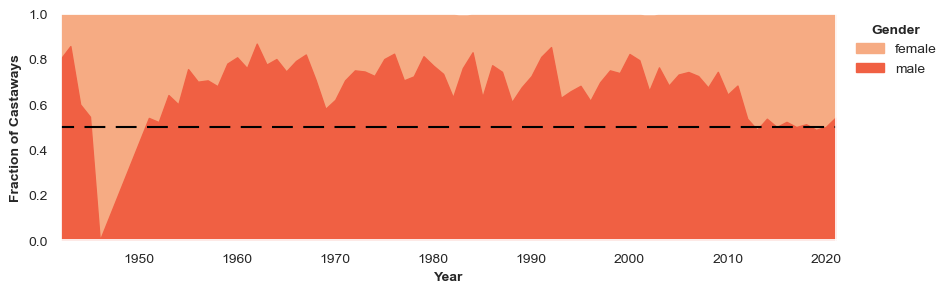

In [6]:
gender_df = pd.pivot_table(castaways_df, columns='gender', index='year', values='date', aggfunc='count')
gender_df = normalize_rows(gender_df)
gender_df = gender_df[['male', 'female']]
gender_df = cumulative_columns(gender_df)
make_timeplot(gender_df, horiz_line_y=0.5, leg_title='Gender')

Okay, there are a few things to notice here. The first is that, throughout the bulk of the show's long history, there have been significantly more male castaways than female. But the plot is very spikey, demonstrating that from year to year the gender ratio of castaways on the show fluctuates by an appreciable amount. Since we are interested in looking at trends over several years, and not differences between consecutive years, lets try smoothing this plot by using a [moving average](https://en.wikipedia.org/wiki/Moving_average) of 5 years.

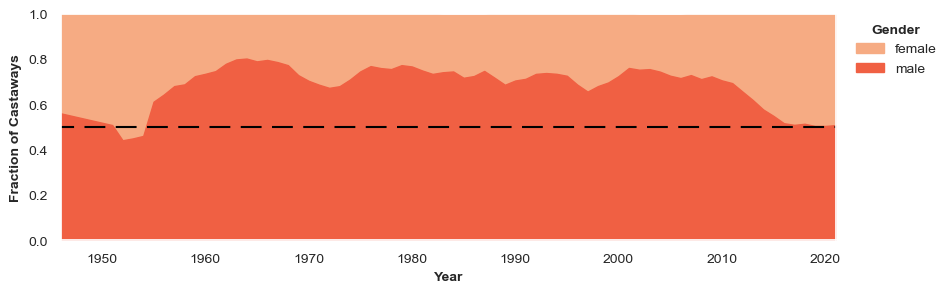

In [7]:
make_timeplot(moving_average(gender_df, n=5), horiz_line_y=0.5, leg_title='Gender')

The smoothed plot confirms the observation that the show has had siginifcantly more females than males. 

Around 1950, it looks as though there was a much more equal split between men and women. However, this conclusion is drawn a bit hurridly. If we look at the number of episodes per year around this time, we see that the show was actually off the air for several years around this period. There was also a year (1946), where only one episode aired, and the castaway was female. As we are giving each year equal visual weight with our plot, the show looks more balanced in terms of gender at it's inception that it probably was. 

From the beginning of the show, up until the early 2010s, there were about 3/4 male castaways and 1/4 female castaways. From about 2013(?check year), we see a qualitative shift, and the split between males and females quickly becomes much more even. The suddenness of this change suggests it was a active decision taken by the producers of the show. The fact that this happened relatively recently is perhaps surprising.

## Age

We might also wonder whether the age of castaways (at the time of them appearing on the show) has changed over time. For example, might recent guests on the show be younger to appeal to a younger demographic of listeners?

Using the date of birth of the castaway from Wikidata, and the air date of the episode, we can calculate how old the castaways were when they were on the show.

<span style="color:red">**TODO**</span>

- [ ] [name=Helen] Oldest and youngest castaways - Put this somewhere that fits in the narrative 

```
<code to print oldest and younest info
```

As we can see there are X people under the age of Y and Z people over the age of ?. Do you recognise any of the names?

- [ ] [name=Helen] Age distribution of castaways. (If the time plot is not interesting, just integrate over time)

Going a bit deeper, we can plot the full age distribution of castaways, integrated over time.
- discuss the plot a bit
- discuss difference/similarities between male/female age distribution




A great example of how the audience and guests are aging together is castaway Sir Cliff Richard. The pop singer [first appeared](https://www.bbc.co.uk/programmes/p009y6z4) on the show at the age of 20 in 1940 (favourite song: Rock Around the Clock by Bill Haley and his Comets, book: The Swiss Family Robinson by Johann Wyss, luxury: guitar) and returned for the 2020 [Christmas epsiode](https://www.bbc.co.uk/programmes/m000qhg8) at the age of 80 (favourite song: It Is Well by Sheila Walsh Featuring Cliff Richard, book: Wuthering Heights by Emily Brontë, luxury: a Gibson acoustic guitar).

### Nationality / Country of Birth

<span style="color:red">**TODO**</span> Finish this section

With the information from Wikipedia, we can also track where the guests are from.

- show (one of) the plots
- talk about how dominant the UK is
- any trends

For a BBC radio programme, perhaps it isn't a surprise that most castaways are from the UK, with other English-speaking countries with cultural connections (Australia, USA) being very prominent. In fact, the large number of castaways from the USA from the start of the show might make sense in the context of castaway profession.


In [8]:
def get_continent(country):
    """
    Fuzzy search for Continent based on input country, treating GB separately
    """
    
    # first search for country
    try:
        code = pc.countries.search_fuzzy(country)[0].alpha_2
    except:
        code = ''
        
    if code == '':
        return 'Unknown'
    
    if code == 'GB':
        return 'GB'
    
    # next get continent code from country code
    continent_code = pcc.country_alpha2_to_continent_code(code)
    
    return continent_code

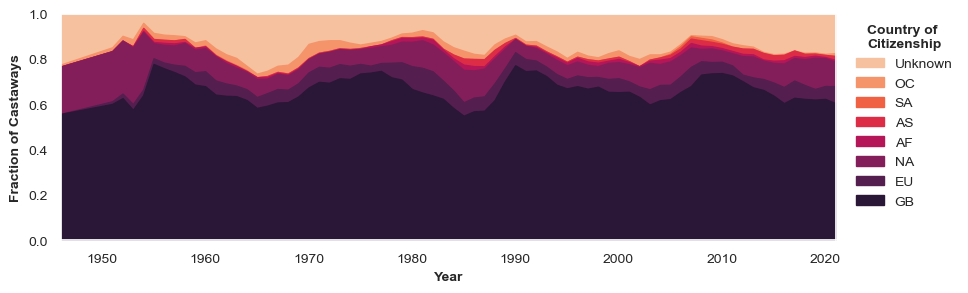

In [9]:
castaways_df['continent_of_citizenship'] = castaways_df.country_of_citizenship.apply(get_continent)
citizenship_df = pd.pivot_table(castaways_df, columns='continent_of_citizenship', 
                                index='year', values='date', aggfunc='count')

citizenship_df = normalize_rows(citizenship_df)
citizenship_df = citizenship_df[['GB', 'EU', 'NA', 'AF', 'AS', 'SA', 'OC', 'Unknown']]
citizenship_df = cumulative_columns(citizenship_df)

make_timeplot(moving_average(citizenship_df, n=5), ymin=0.0, leg_title='Country of \nCitizenship')

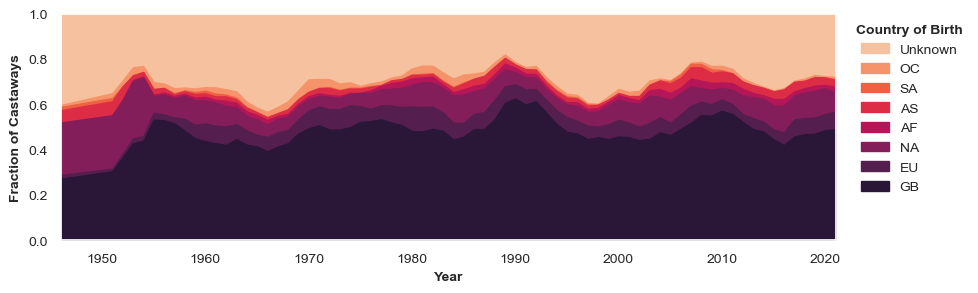

In [11]:
castaways_df['continent_of_birth'] = castaways_df.country_of_birth.apply(get_continent)
birth_df = pd.pivot_table(castaways_df, columns='continent_of_birth', 
                          index='year', values='date', aggfunc='count')

birth_df = normalize_rows(birth_df)
birth_df = birth_df[['GB', 'EU', 'NA', 'AF', 'AS', 'SA', 'OC', 'Unknown']]
birth_df = cumulative_columns(birth_df)

make_timeplot(moving_average(birth_df, n=5), ymin=0.0, leg_title='Country of Birth')

## Profession

<span style="color:red">**TODO**</span> Finish this section


From Wikipedia, we have information about professions, but the data isn't all comparable without some initial work. (Should we include any random examples?)

- talk about profession "heirarchy" obtained from wikidata
- clustering approach taken
- show the plots
- briefly discuss trends

*maybe don't do these:*
- [ ] Which profession is the most/least equal in terms of gender.
- [ ] which professions have the oldest / youngest people.

The professions most frequently represented on Desert Island Discs are people who work in the creative industries - actors, musicians, television personalities. While this makes sense, as it is an entertainment programme with a foundation of music, we were surprised not to see more of a balance between the many professions of "the great and the good".

In [12]:
def reduce(prof_list, common_professions):
    
    # no options available, just take whatever profession is left
    if len(prof_list) == 1 or prof_list[1] == 'professional':
        return [prof_list[0]]
        
    # take the most general profession if it is common
    for prof in prof_list:
        if prof in common_professions and prof != 'professional':
            return [prof]
    
    # if none are common, restrict the set of professions to cluster
    else:
        return prof_list[1:]
    
def cluster_step(profession_lists, n=8):
    
    # get the most common categories
    common_professions = pd.Series([i for x in profession_lists for i in x]).value_counts()[:n]
    
    # apply clustering
    out = [reduce(p, common_professions) for p in profession_lists]
    
    return out

def simplify_professions(profession_lists, n=15, group_n_least_common=25):
    
    # run clustering
    for i in range(10):
        profession_lists = cluster_step(profession_lists)
    
    # clean
    professions = [p[0] for p in profession_lists]
    least_common = pd.Series(professions).value_counts(ascending=True)[:group_n_least_common]
    professions = [p if p not in least_common else 'other' for p in professions]
    
    return professions

In [13]:
def get_profession_plot(df, n=20, window=10, leg_title=''):
    
    profession_df = df.copy()
    profession_df.loc[profession_df.profession == '[]', 'profession'] = np.nan
    profession_df = profession_df.fillna({'profession': "['unknown']"})
    profession_df.profession = profession_df.profession.apply(lambda x: ast.literal_eval(x))
    profession_df['profession'] = simplify_professions(profession_df['profession'], group_n_least_common=n)
    
    prof_df = pd.pivot_table(profession_df, columns='profession', 
                             index='year', values='date', aggfunc='count')

    prof_df = normalize_rows(prof_df)
    prof_df = cumulative_columns(prof_df)

    make_timeplot(moving_average(prof_df, n=window), ymin=0.0, leg_title=leg_title)

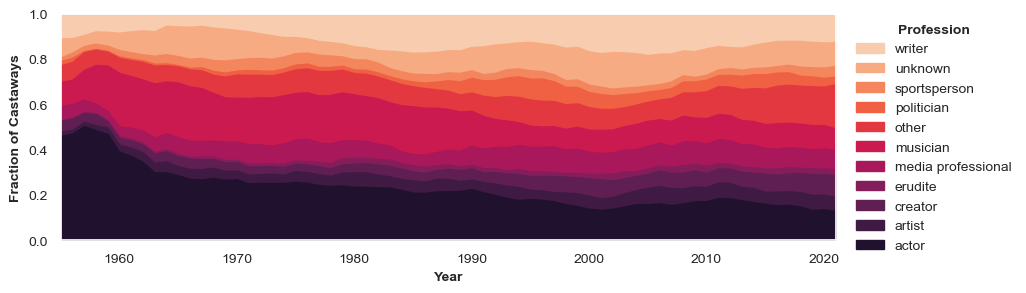

In [14]:
get_profession_plot(castaways_df, n=20, leg_title='Profession')

# Discs

<span style="color:red">**TODO**</span> Finish this section 

<span style="color:red">**TODO**</span> USE LATEST DATA


In the dataset we introduced in the beginning, we also grabbed information about the songs shared by each castaway. Based on Andrew's initial analysis, we know that classical music dominates the musical selections, and we want to dig a little deeper into the types of music chosen over time, as well what types of people choose different genres building on the analysis above.

From Spotify, we can get a list of genres associated with the musical artist and additional info and analysis for each song (for example, danceability). It turns out Spotify has an overwhelming number of microgenres - see Glenn McDonald's everynoise.com for a mind blowing micro-genre experience - and we need to do some work to get a small number of the most common and most easily recognised genres.

Plots:
- [x] Popularity of different genres over time (in particular declining trend of classical music)
- [ ] Plot other spotify info over time, if interesting?


In [15]:
spotify_data = 'https://drive.google.com//uc?export=download&id=1WFdpQmCk0Lhxo223qRRAhj4TRy4GYrDu'
spotify_df = pd.read_csv(spotify_data, index_col=0)
spotify_df.genres_artist = spotify_df.genres_artist.apply(lambda x: ast.literal_eval(x))
spotify_df['date'] = pd.to_datetime(spotify_df['date'])
spotify_df = spotify_df.dropna(subset=['track'])

In [16]:
hc_data_url = 'https://hcommons.org/deposits/download/hc:37504/CONTENT/did_v1.xlsx/'
discs_df = pd.read_excel(hc_data_url, sheet_name='DID_discs_v1', parse_dates=['date'])
merged_df = pd.merge(discs_df, spotify_df, left_on=['track_name', 'date'], right_on=['track_name_original', 'date'], how='inner')

In [18]:
my_genres = {
    'pop': ['easy listening'],
    'rock': [],
    'folk': ['bothy', 'celtic', 'scottish', 'bagpipe', 'irish', 'welsh', 'bluegrass', 'country'],
    'jazz': ['blues', 'british dance band', 'big band', 'ragtime', 'boogie', 'brass band'],
    'classical': ['choral', 'bolero', 'opera', 'operetta', 'orchestral', 'orchestra', 'romantic era', 'light music', 'baroque'],
    'vintage': ['adult standards', 'music hall', 'british comedy', 'broadway', 'cabaret', 'tin pan alley'],
    'world': ['italian', 'chanson', 'french', 'bossa', 'samba', 'flamenco', 'salsa', 'latin', 'african', 'zither', 'cuban rumba', 'arpa paraguaya'],
    'modern': ['disco', 'soul', 'r&b', 'reggae', 'ska', 'hip hop', 'rap', 'electronic', 'electronica', 'house', 'ambient', 'downtempo', 'garage', 'synthesizer', 'drum and bass'],
    'spoken & soundtrack': ['soundtrack', 'hollywood', 'show tunes', 'movie', 'poetry', 'comic', 'reading', 'comedy', 'oratory']
}

def determine_genre(list_of_genres):
    if list_of_genres == []:
        return ''
    for genre in list_of_genres:
        for my_genre in my_genres.keys():
            search_strings = [my_genre] + my_genres[my_genre]
            if any([s in genre for s in search_strings]):
                return my_genre
    return 'other'

In [20]:
merged_df['genre'] = merged_df.genres_artist.apply(determine_genre)
merged_df = merged_df[merged_df['genre'] != ''].copy()
merged_df['genres_artist_str'] = merged_df['genres_artist'].apply(lambda x: str(x))
merged_df['year'] = [i.year for i in merged_df['date'].dt.date]

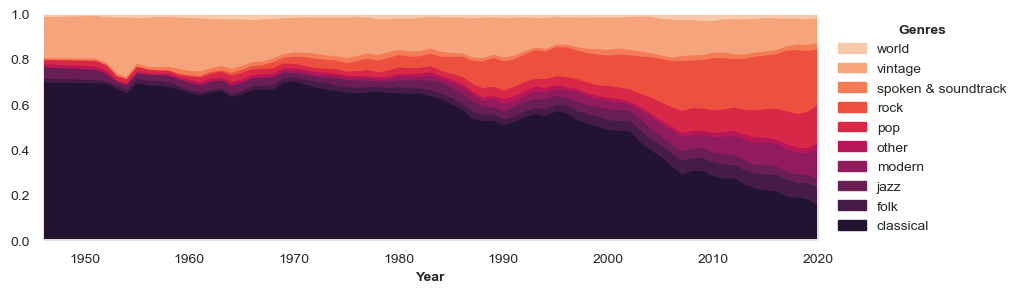

In [21]:
genre_df = pd.pivot_table(merged_df, columns='genre', index='year', values='date', aggfunc='count')
genre_df = normalize_rows(genre_df)
genre_df = cumulative_columns(genre_df)

make_timeplot(moving_average(genre_df, n=5), ymin=0.0, leg_title='Genres', y_title='')

## Castaways + Discs

<span style="color:red">**TODO**</span> Finish this section 


As one final dimension of this story, we want to look at both people and the music that they chose together.

Popularity of different genres by different person type (gender, profession, etc).
- [ ] Does genre preference depend on profession? Could try looking at:
    - [ ] do scientists tend to prefer different styles of music to creatives?
- [ ] Do older/younger people tend to choose different genres

Instead of a deep dive into polticians, we could group everyone into [creative, non-creative, polticians] (maybe just [creative, non-creative] if polticians are not different).
- [ ] Compare genre popularity by these groups

Non-technical - intro to why we are looking closely at politicians. How do their music tastes map to general popularity? How different are politicians of different political parties?

There has been reports that politicans have focus groups to choose their tracks for them, so as to represent themseles in a certain way. Is there any evidence of this in the data? 
- Look into this, is it true?


### Network Analysis

<span style="color:red">**TODO**</span> are we including this? can just mention if it didn't work



> Technical: Description of nework analysis for people. Code.
> * Network of castaways as nodes and edges as common artists (coloured by profession or time period)
>* Investigate comunities in the network 

Todo:
- [ ] Deal with people who have been on the show more than once.


Plots:
- [ ] Are network clusters associated with certain genres
- [ ] Who chose the most weird combination of tracks (e.g. who has the most number of tracks in the "other" genre category)? 
- [ ] who has the least overlap with others in terms of track choice? conversely, who has the most bland choice?


Non-technical: Translate what the network analysis tells us about connections between people and music.


## Discussion

In this data story, we've been looking at some of the trends of people and music on Desert Island Discs. As a mainstay of the BBC Radio schedule, it likely will continue for many decades to come, and this analysis could be continued at future milestones.

- Any caveats? For example: % of people we didn't find in wikipedia, % of songs we didn't find in spotify?
- Future work? Spotify genres



### Invited back to the island

As a listener, each Friday and Sunday morning we are invited back to the island to hear someone's life story through music. But there are some very special guests who are invited back more than once. We close this story by looking at environmentalist and broadcaster David Attenborough's four episodes.

As a fresh 30-year-old TV presenter for his first appearance with Roy Plomley ([06/05/1957](https://www.bbc.co.uk/programmes/p009y8xh)), his first disc was Trouble in Mind by Northern Irish blues singer Ottilie Patterson and Chris Barber Jazz Band. When he returned at the age of 52 ([10/03/1979](https://www.bbc.co.uk/programmes/p009mxny)), he requested to take the book Shifts and Expedients of Camp Life by William Barry Lord to the island, which he consistently requested for his following two appearances. Sue Lawley welcomed back a 72-year-old Attenborough ([25/12/1998](https://www.bbc.co.uk/programmes/p00942qy)) who asked for the luxury of a guitar, having previously taken a piano and binoculars to the island. And finally, for the [70th Anniversary Episode (29/01/2012)](https://www.bbc.co.uk/programmes/b01b8yy0), Kirsty Young invited him back, now 85, where the track he saved from the waves was the 3rd of Johann Sebastian Bach's Goldberg Variations. 

With any luck, Lauren Laverne will invite Sir David back again soon, at which point he will have the record for the most episodes all to himself. As he reflects once more on his life and favourite songs, perhaps he will talk about his evolution into a trusted voice on climate action. Hopefully, the rising seas of climate change don't threaten this island haven of music and life stories.